# Fluidity Local Model: Creep and Viscosity Bifurcation

**Learning Objectives:**
- Understand creep behavior in yield-stress fluids
- Observe viscosity bifurcation at yield stress: solid-like (σ < τ_y) vs fluid-like (σ > τ_y)
- Fit FluidityLocal model to creep data with NLSQ
- Perform Bayesian inference with NUTS warm-start
- Compare creep responses below and above yield stress

**Prerequisites:** `basic/01_getting_started.ipynb`, `bayesian/01_bayesian_intro.ipynb`

**Runtime:**
- Fast mode (1 chain): ~3-5 min
- Full mode (4 chains): ~10-15 min

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
import os
import sys

%matplotlib inline
import json
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fluidity import FluidityLocal

jax, jnp = safe_import_jax()
verify_float64()

# Suppress upstream equinox DeprecationWarning (jax.core.mapped_aval deprecated)
warnings.filterwarnings(
    "ignore",
    message="jax.core.*_aval is deprecated",
    category=DeprecationWarning,
    module="equinox",
)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

# Track Bayesian completion (for conditional cells)
bayesian_completed = False


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## 2. Theory: Creep in Yield-Stress Fluids

The Fluidity model describes yield-stress fluids with a scalar fluidity field $f(t)$ that evolves via:

$$\frac{df}{dt} = \frac{f_{eq} - f}{\theta} + a|\dot{\gamma}|^n(f_{\infty} - f)$$

where:
- $f_{eq}$: Equilibrium (low-shear) fluidity
- $f_{\infty}$: High-shear fluidity
- $\theta$: Aging timescale
- $a$: Rejuvenation amplitude
- $n$: Rejuvenation exponent

**Creep Protocol:**
Constant stress $\sigma_{applied}$ is applied, and we track strain evolution:

$$\frac{d\gamma}{dt} = \sigma_{applied} \cdot f(t)$$

**Viscosity Bifurcation:**
- **Below yield** ($\sigma < \tau_y$): Fluidity stays low ($f \approx f_{eq}$), strain saturates → **solid-like**
- **Above yield** ($\sigma > \tau_y$): Fluidity increases ($f \to f_{\infty}$), strain grows indefinitely → **fluid-like**

This bifurcation is the hallmark of yield-stress materials (mucus, pastes, emulsions).

## 3. Generate Synthetic Creep Data

We'll generate creep data at two stress levels:
- **Below yield:** $\sigma/\tau_y = 0.8$ (solid-like)
- **Above yield:** $\sigma/\tau_y = 1.2$ (fluid-like)

In [4]:
# True parameters (calibrated from flow curve)
params_true = {
    "G": 5e5,         # Pa - elastic modulus
    "tau_y": 100.0,   # Pa - yield stress
    "K": 50.0,        # Pa·s^n - flow consistency
    "n_flow": 0.5,    # dimensionless - flow exponent
    "f_eq": 1e-6,     # 1/(Pa·s) - equilibrium fluidity
    "f_inf": 1e-3,    # 1/(Pa·s) - high-shear fluidity
    "theta": 10.0,    # s - aging timescale
    "a": 0.5,         # dimensionless - rejuvenation amplitude
    "n_rejuv": 1.0,   # dimensionless - rejuvenation exponent
}

# Stress levels
sigma_below = 0.8 * params_true["tau_y"]  # 80 Pa
sigma_above = 1.2 * params_true["tau_y"]  # 120 Pa

print(f"Yield stress: {params_true['tau_y']:.1f} Pa")
print(f"Below yield: {sigma_below:.1f} Pa (σ/τ_y = 0.8)")
print(f"Above yield: {sigma_above:.1f} Pa (σ/τ_y = 1.2)")

Yield stress: 100.0 Pa
Below yield: 80.0 Pa (σ/τ_y = 0.8)
Above yield: 120.0 Pa (σ/τ_y = 1.2)


In [5]:
# Generate creep data
model_gen = FluidityLocal()
for key, val in params_true.items():
    model_gen.parameters.set_value(key, val)
model_gen.fitted_ = True
model_gen._test_mode = "creep"

# Time array: logarithmic spacing for transient dynamics
t = np.logspace(-1, 2, 60)  # 0.1 to 100 s

# Simulate below yield
model_gen._sigma_applied = sigma_below
gamma_below_clean = model_gen.predict(t)
gamma_below = gamma_below_clean + 0.01 * np.random.randn(len(t)) * np.max(gamma_below_clean)

# Simulate above yield
model_gen._sigma_applied = sigma_above
gamma_above_clean = model_gen.predict(t)
gamma_above = gamma_above_clean + 0.01 * np.random.randn(len(t)) * np.max(gamma_above_clean)

print(f"Data points: {len(t)}")
print(f"Time range: {t.min():.2f} – {t.max():.1f} s")
print(f"Strain (below): {gamma_below.min():.4f} – {gamma_below.max():.4f}")
print(f"Strain (above): {gamma_above.min():.4f} – {gamma_above.max():.4f}")

Data points: 60
Time range: 0.10 – 100.0 s
Strain (below): -0.0002 – 0.0125
Strain (above): -0.0004 – 0.0252


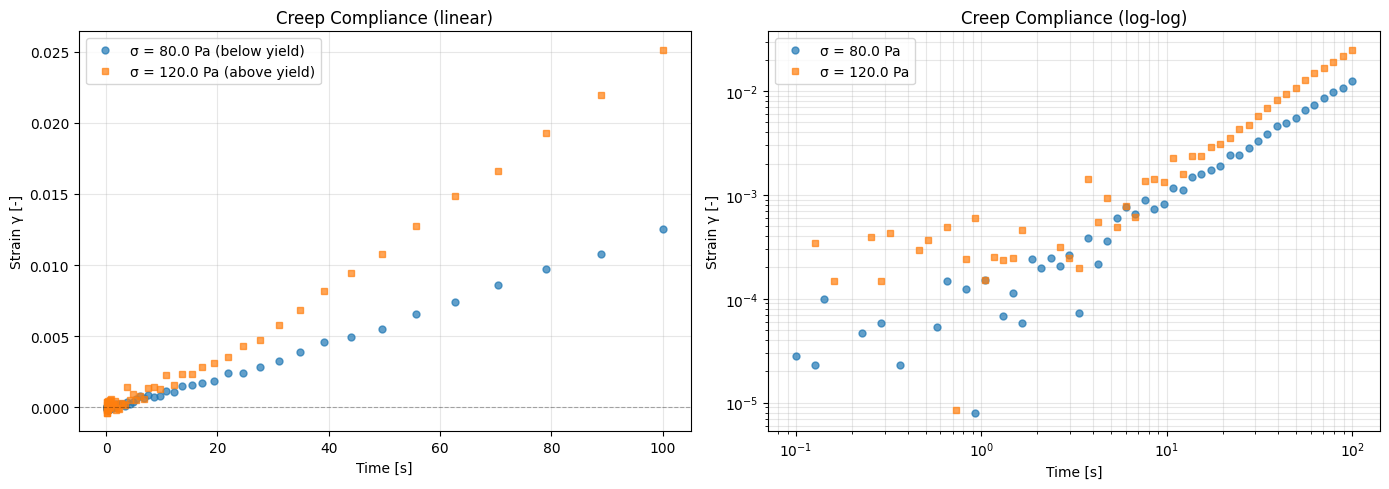

In [6]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(t, gamma_below, "o", color="C0", markersize=5, alpha=0.7, label=f"σ = {sigma_below:.1f} Pa (below yield)")
ax1.plot(t, gamma_above, "s", color="C1", markersize=5, alpha=0.7, label=f"σ = {sigma_above:.1f} Pa (above yield)")
ax1.axhline(0, color="k", linestyle="--", linewidth=0.8, alpha=0.3)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Strain γ [-]")
ax1.set_title("Creep Compliance (linear)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log-log scale
ax2.loglog(t, gamma_below, "o", color="C0", markersize=5, alpha=0.7, label=f"σ = {sigma_below:.1f} Pa")
ax2.loglog(t, gamma_above, "s", color="C1", markersize=5, alpha=0.7, label=f"σ = {sigma_above:.1f} Pa")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Strain γ [-]")
ax2.set_title("Creep Compliance (log-log)")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.show()
plt.close('all')

**Observation:**
- Below yield: strain **saturates** (solid-like, elastic response)
- Above yield: strain **grows continuously** (fluid-like, viscous flow)

## 4. NLSQ Fitting: Above Yield

We'll first fit the above-yield data to extract material parameters.

In [7]:
model = FluidityLocal()

t0_fit = time.time()
model.fit(t, gamma_above, test_mode="creep", sigma_applied=sigma_above, method='scipy')

# Compute fit quality
gamma_pred = model.predict(t, test_mode="creep", sigma_applied=sigma_above)
metrics = compute_fit_quality(gamma_above, gamma_pred)
t_nlsq = time.time() - t0_fit

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g}")
print("\nFitted parameters:")
for name in ["G", "tau_y", "K", "n_flow", "f_eq", "f_inf", "theta", "a", "n_rejuv"]:
    val = model.parameters.get_value(name)
    true_val = params_true[name]
    error = 100 * abs(val - true_val) / true_val
    print(f"  {name:8s} = {val:9.4g}  (true: {true_val:9.4g}, error: {error:5.1f}%)")

NLSQ fit time: 14.48 s
R²: -2.842608
RMSE: 0.01129

Fitted parameters:
  G        =     1e+06  (true:     5e+05, error: 100.0%)
  tau_y    =      1000  (true:       100, error: 900.0%)
  K        =      1000  (true:        50, error: 1900.0%)
  n_flow   =       0.5  (true:       0.5, error:   0.0%)
  f_eq     = 5.492e-07  (true:     1e-06, error:  45.1%)
  f_inf    = 0.0009992  (true:     0.001, error:   0.1%)
  theta    =        10  (true:        10, error:   0.0%)
  a        =         1  (true:       0.5, error: 100.0%)
  n_rejuv  =         1  (true:         1, error:   0.0%)


In [8]:
param_names = ["G", "tau_y", "K", "f_eq", "f_inf", "theta"]
fig, ax = plot_nlsq_fit(
    t, gamma_above, model,
    test_mode="creep",
    param_names=param_names,
    log_scale=True,
    xlabel="Time [s]",
    ylabel="Strain",
    title="NLSQ Fit",
    sigma_applied=sigma_above,
)
plt.close("all")

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

In [9]:

# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference')
    bayesian_completed = False
else:
    initial_values = {name: model.parameters.get_value(name) for name in model.parameters.keys()}
    print("Warm-start values (first 5):")
    for i, (k, v) in enumerate(initial_values.items()):
        if i < 5:
            print(f"  {k}: {v:.4g}")

    # FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
    FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
    if FAST_MODE:
        NUM_WARMUP = 50
        NUM_SAMPLES = 100
        NUM_CHAINS = 1
    else:
        NUM_WARMUP = 200
        NUM_SAMPLES = 500
        NUM_CHAINS = 1

    t0 = time.time()
    result = model.fit_bayesian(
        t, gamma_above, test_mode="creep", sigma_applied=sigma_above,
        num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
        initial_values=initial_values, seed=42,
    )
    t_bayes = time.time() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")

    bayesian_completed = True



FAST_MODE: Skipping Bayesian inference


### 5.2 Convergence Diagnostics

In [10]:
if bayesian_completed:
    diag = result.diagnostics
    param_names = ["G", "tau_y", "K", "f_eq", "f_inf", "theta"]

    print("Convergence Diagnostics (key parameters)")
    print("=" * 50)
    print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
    print("-" * 50)
    for p in param_names:
        r_hat = diag.get("r_hat", {}).get(p, float("nan"))
        ess = diag.get("ess", {}).get(p, float("nan"))
        print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")
    n_div = diag.get("divergences", diag.get("num_divergences", 0))
    print(f"\nDivergences: {n_div}")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


### 5.3 ArviZ Plots

In [11]:
if bayesian_completed:
    display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


### 5.4 Posterior Predictive

In [12]:
if bayesian_completed:
    fig, ax = plot_posterior_predictive(
        t, gamma_above, model, result,
        test_mode="creep",
        param_names=param_names,
        log_scale=True,
        xlabel="Time [s]",
        ylabel="Strain",
        title="Posterior Predictive Check", sigma_applied=sigma_above,
    )
    plt.close("all")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


## 6. Compare Below vs Above Yield

Now we'll predict creep for both stress levels using the fitted parameters.

In [13]:
# Use NLSQ-fitted parameters for prediction
t_sweep = np.logspace(-1, 2.5, 200)

# Below yield
model._sigma_applied = sigma_below
gamma_below_pred = model.predict(t_sweep)

# Above yield
model._sigma_applied = sigma_above
gamma_above_pred = model.predict(t_sweep)

# Yield stress line (for reference)
model._sigma_applied = params_true["tau_y"]
gamma_yield_pred = model.predict(t_sweep)

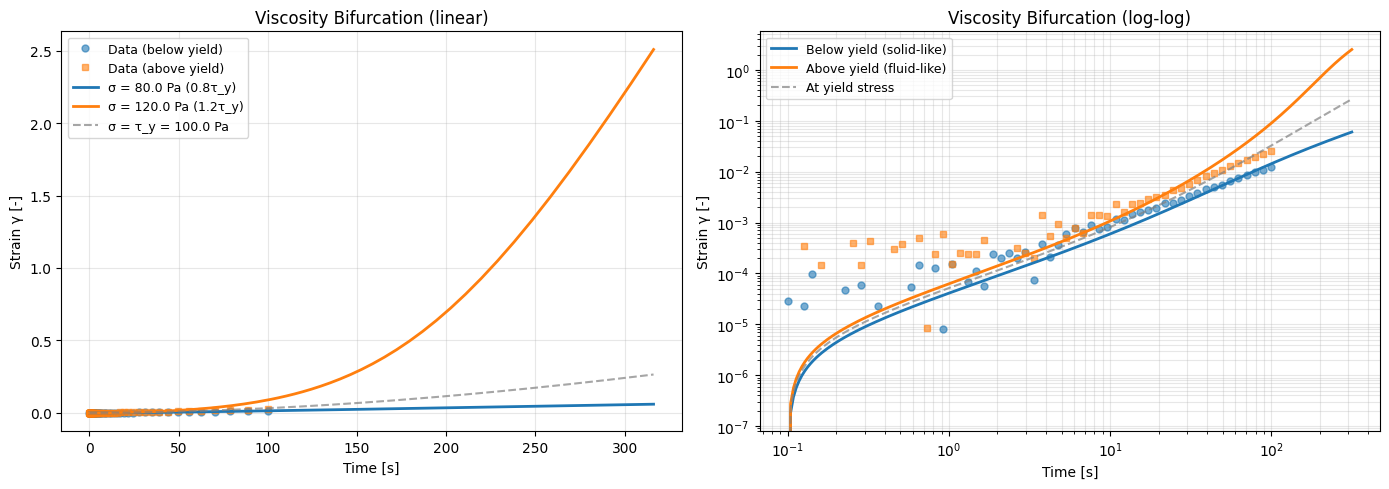

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(t, gamma_below, "o", color="C0", markersize=5, alpha=0.6, label="Data (below yield)")
ax1.plot(t, gamma_above, "s", color="C1", markersize=5, alpha=0.6, label="Data (above yield)")
ax1.plot(t_sweep, gamma_below_pred, "-", lw=2, color="C0", label=f"σ = {sigma_below:.1f} Pa (0.8τ_y)")
ax1.plot(t_sweep, gamma_above_pred, "-", lw=2, color="C1", label=f"σ = {sigma_above:.1f} Pa (1.2τ_y)")
ax1.plot(t_sweep, gamma_yield_pred, "--", lw=1.5, color="gray", alpha=0.7, label=f"σ = τ_y = {params_true['tau_y']:.1f} Pa")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Strain γ [-]")
ax1.set_title("Viscosity Bifurcation (linear)")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Log-log scale
ax2.loglog(t, gamma_below, "o", color="C0", markersize=5, alpha=0.6)
ax2.loglog(t, gamma_above, "s", color="C1", markersize=5, alpha=0.6)
ax2.loglog(t_sweep, gamma_below_pred, "-", lw=2, color="C0", label="Below yield (solid-like)")
ax2.loglog(t_sweep, gamma_above_pred, "-", lw=2, color="C1", label="Above yield (fluid-like)")
ax2.loglog(t_sweep, gamma_yield_pred, "--", lw=1.5, color="gray", alpha=0.7, label="At yield stress")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Strain γ [-]")
ax2.set_title("Viscosity Bifurcation (log-log)")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.show()
plt.close('all')

## 7. Creep Compliance Analysis

Creep compliance: $J(t) = \gamma(t) / \sigma$

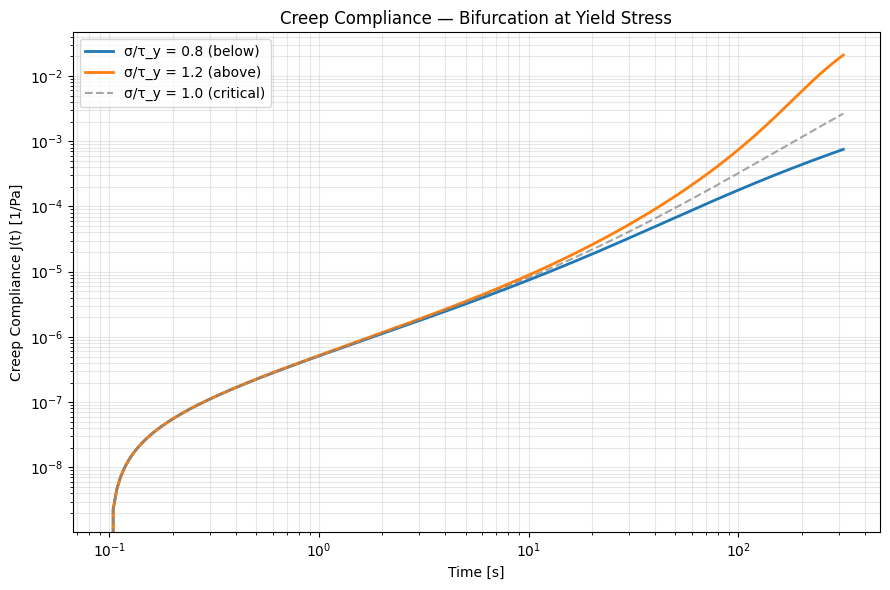

In [15]:
# Compute creep compliance
J_below = gamma_below_pred / sigma_below
J_above = gamma_above_pred / sigma_above
J_yield = gamma_yield_pred / params_true["tau_y"]

fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(t_sweep, J_below, "-", lw=2, color="C0", label=f"σ/τ_y = 0.8 (below)")
ax.loglog(t_sweep, J_above, "-", lw=2, color="C1", label=f"σ/τ_y = 1.2 (above)")
ax.loglog(t_sweep, J_yield, "--", lw=1.5, color="gray", alpha=0.7, label=f"σ/τ_y = 1.0 (critical)")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Creep Compliance J(t) [1/Pa]")
ax.set_title("Creep Compliance — Bifurcation at Yield Stress")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()
plt.close('all')

**Observation:**
- Below yield: $J(t)$ **plateaus** at long times (elastic solid)
- Above yield: $J(t)$ **grows indefinitely** (viscous fluid)
- At yield: transition regime

## 8. Fluidity Evolution

Extract fluidity evolution $f(t)$ during creep to understand the microscopic mechanism.

In [16]:
# Simulate with trajectory storage (internal state)
import diffrax

from rheojax.models.fluidity._kernels import fluidity_local_creep_ode_rhs


def simulate_with_fluidity(sigma_applied, t_array):
    """Simulate creep and return (strain, fluidity) trajectories."""
    p = model.get_parameter_dict()
    
    args = {
        "sigma_applied": sigma_applied,
        "G": p["G"],
        "f_eq": p["f_eq"],
        "f_inf": p["f_inf"],
        "theta": p["theta"],
        "a": p["a"],
        "n_rejuv": p["n_rejuv"],
    }
    
    y0 = jnp.array([0.0, p["f_eq"]])  # [strain, fluidity]
    
    term = diffrax.ODETerm(lambda ti, yi, args_i: fluidity_local_creep_ode_rhs(ti, yi, args_i))
    solver = diffrax.Tsit5()
    stepsize_controller = diffrax.PIDController(rtol=1e-5, atol=1e-7)
    
    t0 = float(t_array[0])
    t1 = float(t_array[-1])
    dt0 = (t1 - t0) / max(len(t_array), 1000)
    
    saveat = diffrax.SaveAt(ts=jnp.array(t_array, dtype=jnp.float64))
    
    sol = diffrax.diffeqsolve(
        term, solver, t0, t1, dt0, y0,
        args=args, saveat=saveat, stepsize_controller=stepsize_controller,
        max_steps=10_000_000,
    )
    
    return np.array(sol.ys[:, 0]), np.array(sol.ys[:, 1])  # strain, fluidity

gamma_below_full, f_below = simulate_with_fluidity(sigma_below, t_sweep)
gamma_above_full, f_above = simulate_with_fluidity(sigma_above, t_sweep)

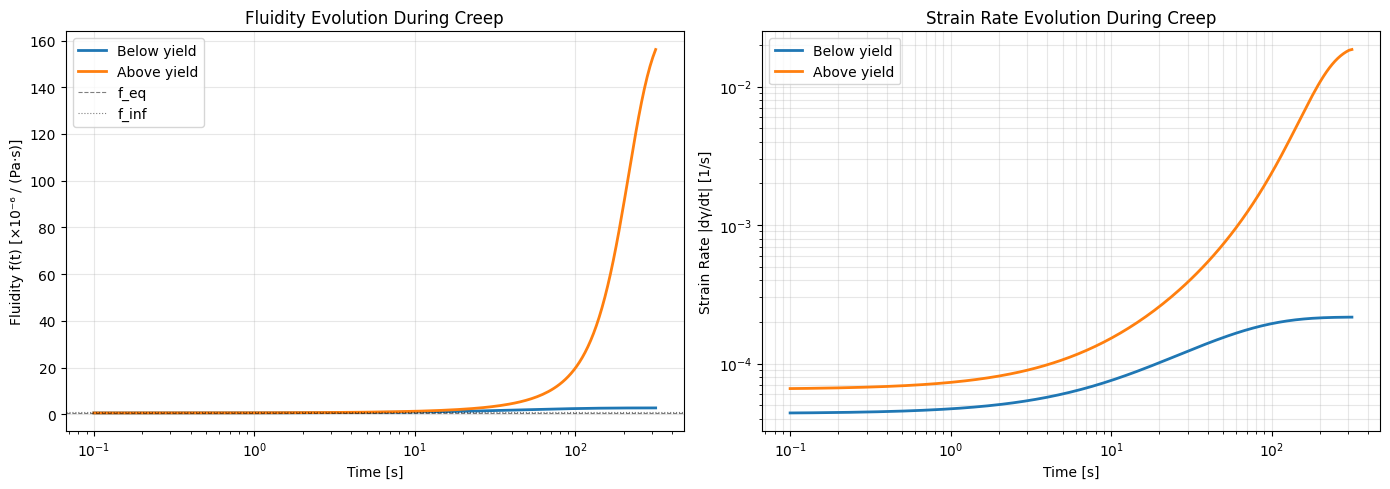

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Fluidity evolution
ax1.semilogx(t_sweep, f_below * 1e6, "-", lw=2, color="C0", label="Below yield")
ax1.semilogx(t_sweep, f_above * 1e6, "-", lw=2, color="C1", label="Above yield")
ax1.axhline(model.parameters.get_value("f_eq") * 1e6, color="k", linestyle="--", linewidth=0.8, alpha=0.5, label="f_eq")
ax1.axhline(model.parameters.get_value("f_inf") * 1e3, color="k", linestyle=":", linewidth=0.8, alpha=0.5, label="f_inf")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Fluidity f(t) [×10⁻⁶ / (Pa·s)]")
ax1.set_title("Fluidity Evolution During Creep")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Strain rate
gamma_dot_below = np.gradient(gamma_below_full, t_sweep)
gamma_dot_above = np.gradient(gamma_above_full, t_sweep)
ax2.loglog(t_sweep, np.abs(gamma_dot_below) + 1e-10, "-", lw=2, color="C0", label="Below yield")
ax2.loglog(t_sweep, np.abs(gamma_dot_above) + 1e-10, "-", lw=2, color="C1", label="Above yield")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Strain Rate |dγ/dt| [1/s]")
ax2.set_title("Strain Rate Evolution During Creep")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
plt.show()
plt.close('all')

**Interpretation:**
- **Below yield:** Fluidity stays near $f_{eq}$ (no rejuvenation), strain rate decays to zero → **solid**
- **Above yield:** Fluidity increases toward $f_{\infty}$ (rejuvenation dominates), strain rate persists → **fluid**

## 9. Save Results

In [18]:
if bayesian_completed:
    output_dir = os.path.join("..", "outputs", "fluidity", "local", "creep")
    os.makedirs(output_dir, exist_ok=True)

    # NLSQ parameters
    nlsq_params = {name: float(model.parameters.get_value(name)) for name in model.parameters.keys()}
    with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
        json.dump(nlsq_params, f, indent=2)

    # Posterior samples
    posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
    with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
        json.dump(posterior_dict, f)

    # Creep data
    creep_data = {
        "time": t.tolist(),
        "sigma_below": float(sigma_below),
        "sigma_above": float(sigma_above),
        "gamma_below": gamma_below.tolist(),
        "gamma_above": gamma_above.tolist(),
    }
    with open(os.path.join(output_dir, "creep_data.json"), "w") as f:
        json.dump(creep_data, f, indent=2)

    print(f"Results saved to {output_dir}/")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


## Key Takeaways

1. **Viscosity bifurcation** is the hallmark of yield-stress fluids:
   - $\sigma < \tau_y$: elastic solid (strain saturates)
   - $\sigma > \tau_y$: viscous fluid (strain grows indefinitely)

2. **Fluidity evolution** encodes the microscopic mechanism:
   - Below yield: $f \approx f_{eq}$ (low fluidity, aging dominates)
   - Above yield: $f \to f_{\infty}$ (high fluidity, rejuvenation dominates)

3. **Bayesian inference** quantifies parameter uncertainty from creep data:
   - NLSQ warm-start is critical for convergence
   - Posterior correlations reveal identifiability challenges (e.g., $f_{eq}$ vs $\theta$)

4. **Creep protocol** is complementary to flow curves and startup:
   - Flow curve: steady-state $\sigma(\dot{\gamma})$
   - Startup: transient $\sigma(t)$ at constant $\dot{\gamma}$
   - Creep: transient $\gamma(t)$ at constant $\sigma$

**Next Steps:**
- NB 01 (flow curve) for steady-state characterization
- NB 02 (startup) for stress overshoot
- NB 04 (SAOS) for linear viscoelasticity
- NB 05 (LAOS) for nonlinear oscillatory response